# Cars

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import os
import pandas as pd

import cv2
import albumentations as A


import torch
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, datasets
import torchmetrics
from torchsummary import summary


from sklearn.model_selection import train_test_split

import PIL
from PIL import ImageOps, ImageFilter

from transformers import ViTFeatureExtractor, ViTForImageClassification

/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 2.0.2 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


# Settings

In [2]:
EPOCHS               = 5
BATCH_SIZE           = 32
LR                   = 1e-3
VAL_SPLIT            = 0.2

NUM_CLASSES            = 10
IMG_SIZE             = 224
IMG_CHANNELS         = 3
input_shape          = (IMG_SIZE, IMG_SIZE, IMG_CHANNELS)

input_folder = '/kaggle/input/cars-data/train/train/'

# Analys

In [3]:
file_names = []
labels = []

# Проход по всем папкам и файлам
for class_folder in os.listdir(input_folder):
    class_folder_path = os.path.join(input_folder, class_folder)
    if os.path.isdir(class_folder_path):  
        for filename in os.listdir(class_folder_path):
            if filename.endswith('.jpg'):
                file_names.append(input_folder+class_folder+'/'+filename)
                labels.append(class_folder) 

In [4]:
dataset = pd.DataFrame({'filename': file_names, 'class': labels})
dataset.head(10)

,filename,class
0,/kaggle/input/cars-data/train/train/7/12666.jpg,7
1,/kaggle/input/cars-data/train/train/7/153872.jpg,7
2,/kaggle/input/cars-data/train/train/7/255340.jpg,7
3,/kaggle/input/cars-data/train/train/7/171216.jpg,7
4,/kaggle/input/cars-data/train/train/7/178170.jpg,7
5,/kaggle/input/cars-data/train/train/7/192464.jpg,7
6,/kaggle/input/cars-data/train/train/7/251718.jpg,7
7,/kaggle/input/cars-data/train/train/7/246757.jpg,7
8,/kaggle/input/cars-data/train/train/7/265887.jpg,7
9,/kaggle/input/cars-data/train/train/7/131201.jpg,7


In [5]:
dataset['class'].value_counts(normalize=True)

class
1    0.126663
8    0.113425
6    0.111368
5    0.104813
0    0.103657
3    0.098194
2    0.093696
4    0.089969
9    0.080650
7    0.077566
Name: proportion, dtype: float64

The class imbalance is low.
Let's take a look at a few examples.

In [6]:
example = dataset.sample(9)
ex_path = example['filename'].values
ex_cl = example['class'].values

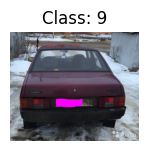

(507, 428)


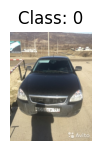

(360, 480)


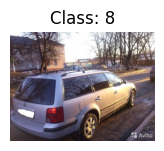

(640, 480)


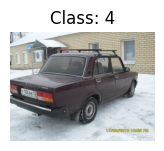

(640, 480)


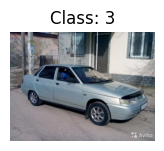

(640, 480)


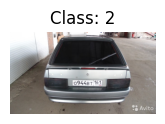

(640, 360)


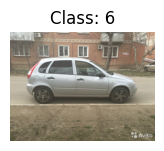

(640, 480)


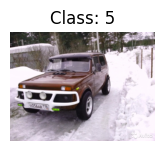

(640, 480)


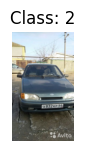

(270, 480)


In [7]:
for idx, path in enumerate(ex_path):
    im = PIL.Image.open(path)
    plt.subplot(3, 3, idx+1)
    plt.imshow(im)
    plt.title('Class: '+str(ex_cl[idx]))
    plt.axis('off')
    plt.show()
    print(im.size)

# Prepocessing

In [8]:
dataset = datasets.ImageFolder(root=input_folder, transform=None)

In [9]:
train_size = int((1 - VAL_SPLIT) * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

## Transforms

Let's apply augmentation to make the data more diverse.

In [10]:
augmentation = A.Compose([
#    A.RandomRotate90(p=0.1),
    A.HorizontalFlip(p=0.5),
#    A.VerticalFlip(p=0.1),
#    A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=20, border_mode=0),
    A.RandomBrightnessContrast(brightness_limit=0.15, contrast_limit=0.15, p=0.4),
    A.HueSaturationValue(hue_shift_limit=10, sat_shift_limit=10, val_shift_limit=10, p=0.4)
])

transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])


In [11]:
class TDataset(Dataset):
    def __init__(self, dataset, augmentation=None, transform=transform):
        self.dataset = dataset
        self.augmentation = augmentation
        self.transform = transform
  
    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image, label = self.dataset[idx]
        image = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2BGR)

        if self.augmentation:
            augmented = self.augmentation(image=image)
            image = augmented['image']

        image = self.transform(image)

        return image, label


In [12]:
train_dataset_aug = TDataset(train_dataset, augmentation=augmentation)
val_dataset_trans = TDataset(val_dataset)

In [13]:
train_loader = DataLoader(train_dataset_aug, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset_trans, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

Let's check if the data in the DataLoader is correct.

In [14]:
for images, labels in train_loader:
    if images is not None: 
        print(images.shape, labels)
        break

torch.Size([32, 3, 224, 224]) tensor([5, 7, 0, 0, 5, 4, 2, 8, 9, 0, 0, 2, 6, 4, 5, 7, 1, 3, 1, 9, 5, 5, 0, 3,
        2, 4, 4, 4, 6, 4, 5, 9])


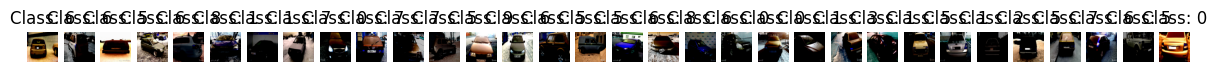

In [15]:
data_iter = iter(train_loader)
images, labels = next(data_iter)

num_images = len(images)
fig, axes = plt.subplots(1, num_images, figsize=(15, 5))

for idx in range(num_images):
    axes[idx].imshow(images[idx].permute(1, 2, 0).numpy()) 
    axes[idx].set_title(f'Class: {labels[idx].item()}') 
    axes[idx].axis('off')

plt.show()

# Pipeline

In [16]:
class Pipeline(pl.LightningModule):
    def __init__(self,
                 model,
                 criterion=nn.CrossEntropyLoss(),
                 optimizer_class=torch.optim.AdamW,
                 lr=0.001
                 ):
        super().__init__()
        self.model = model
        self.criterion = criterion
        self.optimizer_class = optimizer_class
        self.lr = lr
        self.train_acc = torchmetrics.Accuracy(task='multiclass', num_classes=10)
        self.val_acc = torchmetrics.Accuracy(task='multiclass', num_classes=10)
        self.test_acc = torchmetrics.Accuracy(task='multiclass', num_classes=10)
        self.f1 = torchmetrics.F1Score(task='multiclass', num_classes=10)

    def configure_optimizers(self):
        optimizer = self.optimizer_class(self.model.parameters(), lr=self.lr)
        return optimizer

    def training_step(self, batch, batch_idx):
        x, y = batch
        out = self.model(x)
        loss = self.criterion(out, y)
        self.train_acc.update(out, y)
        self.log("train_loss", loss, prog_bar=True)
        self.log("train_accuracy", self.train_acc, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        out = self.model(x)
        loss = self.criterion(out, y)
        self.val_acc.update(out, y)
        self.log('val_accuracy', self.val_acc, prog_bar=True)
        self.log("val_loss", loss, prog_bar=True)

    def on_train_epoch_end(self):
        self.train_acc.reset()

        self.val_acc.reset()

    def test_step(self, batch, batch_idx):
        x, y = batch
        out = self.model(x)
        loss = self.criterion(out, y)
        self.test_acc.update(out, y)
        self.f1.update(out, y)
        self.log('test_accuracy', self.test_acc, prog_bar=True)
        self.log("test_loss", loss)

        

    def on_test_epoch_end(self):
        self.log("test_accuracy_final", self.test_acc.compute())
        self.test_acc.reset()

        self.log("f1_score", self.f1.compute())
        self.f1.reset()

# Model

In [17]:
class MyModel(nn.Module):
    def __init__(self, num_classes=NUM_CLASSES):
        super(MyModel, self).__init__()

        self.activation = nn.ReLU()
        self.pool = nn.MaxPool2d(2,2)
        self.drop1 = nn.Dropout(0.3)
        self.flatten = nn.Flatten()

        self.conv1 = self._conv_layer(3, 96)
        self.conv2 = self._conv_layer(96, 256)
        self.conv3 = self._conv_layer(256, 384)
        self.conv4 = self._conv_layer(384, 384)
        self.conv5 = self._conv_layer(384, 256)


        self.conv_reduce1 = nn.Conv2d(in_channels=352, out_channels=256, kernel_size=1)
        self.conv_reduce2 = nn.Conv2d(in_channels=768, out_channels=384, kernel_size=1)

        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc1 = nn.Linear(256, 512)
        self.fc3 = nn.Linear(512, num_classes)

    def _conv_layer(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        )


    def forward(self, x):
        x = self.conv1(x)
        x1 = self.pool(x)
        x = self.conv2(x1)
        x = self.pool(x)
        x1 = self.pool(x1)
        x = self.conv_reduce1(torch.cat((x, x1), dim=1))        
        x1 = self.conv3(x)
        x = self.conv4(x1)
        x = self.conv_reduce2(torch.cat((x, x1), dim=1))
        x = self.conv5(x)
        x = self.pool(x)
        x = self.global_pool(x)
        x = self.flatten(x)
        x = self.drop1(self.activation(self.fc1(x)))
        x = self.fc3(x)
        return x

In [18]:
model = MyModel()

In [19]:
early_stopping_callback = EarlyStopping(
    monitor='val_accuracy',
    mode='max',
    patience=5,
    verbose=True)
checkpoint_callback = ModelCheckpoint(
    monitor='val_accuracy',
    dirpath='checkpoints/', 
    filename='best-model',  
    verbose=True,
    mode='max',
    save_top_k=1)

In [25]:
trainer = pl.Trainer(
    max_epochs=55,                    
    logger=pl.loggers.tensorboard.TensorBoardLogger(save_dir="./final_log/"),
    callbacks=[checkpoint_callback, early_stopping_callback]  
)
pipeline = Pipeline(model=model)

In [26]:
trainer.fit(
    model=pipeline,
    train_dataloaders=train_loader,
    val_dataloaders=val_loader
)

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /kaggle/working/checkpoints exists and is not empty.


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

In [27]:
trainer.test(model=pipeline, dataloaders=val_loader)

Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         f1_score          │    0.8050112724304199     │
│       test_accuracy       │    0.8050112724304199     │
│    test_accuracy_final    │    0.8050112724304199     │
│         test_loss         │     0.584479570388794     │
└───────────────────────────┴───────────────────────────┘

[{'test_accuracy': 0.8050112724304199,
  'test_loss': 0.584479570388794,
  'test_accuracy_final': 0.8050112724304199,
  'f1_score': 0.8050112724304199}]

In [23]:
%load_ext tensorboard

In [24]:
%tensorboard --logdir ./final_log/

<IPython.core.display.Javascript object>

The task with F1 > 70% is completed! Now let's try a pre-trained model.

# Transfer Learning

In [28]:
feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224-in21k')
model = ViTForImageClassification.from_pretrained(
    'google/vit-base-patch16-224-in21k',
    num_labels=NUM_CLASSES
)

preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [29]:
model

ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTSdpaAttention(
            (attention): ViTSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_fe

First, let's train only the classifier.

In [30]:
for param in model.base_model.parameters():
    param.requires_grad = False

In [31]:
feature_extractor

ViTFeatureExtractor {
  "do_convert_rgb": null,
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_processor_type": "ViTFeatureExtractor",
  "image_std": [
    0.5,
    0.5,
    0.5
  ],
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 224,
    "width": 224
  }
}

In [32]:
class ImageClassificationCollator:
    def __init__(self, feature_extractor):
        self.feature_extractor = feature_extractor

    def __call__(self, batch):

        images = [x[0] for x in batch]
        labels = torch.tensor([x[1] for x in batch], dtype=torch.long) 

        encodings = self.feature_extractor(images, return_tensors='pt'#, padding=True
                                          )
        encodings['labels'] = labels

        return encodings

In [33]:
collator = ImageClassificationCollator(feature_extractor)
train_loader = DataLoader(train_dataset, batch_size=8, collate_fn=collator, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=8, collate_fn=collator, shuffle=False, num_workers=2)


In [34]:
class Classifier(pl.LightningModule):

    def __init__(self, model, lr: float = 0.001):
        super().__init__()
        self.lr = lr
        self.model = model
        self.forward = self.model.forward
        self.train_acc = torchmetrics.Accuracy(task='multiclass', num_classes=10)
        self.val_acc = torchmetrics.Accuracy(task='multiclass', num_classes=10)
        self.test_acc = torchmetrics.Accuracy(task='multiclass', num_classes=10)
        self.f1 = torchmetrics.F1Score(task='multiclass', num_classes=10)

    def training_step(self, batch, batch_idx):
        outputs = self(**batch)
        self.log(f"train_loss", outputs.loss)
        self.train_acc.update(outputs.logits.argmax(1), batch['labels'])
        self.log("train_accuracy", self.train_acc, prog_bar=True)
        return outputs.loss

    def validation_step(self, batch, batch_idx):
        outputs = self(**batch)
        self.log("val_loss", outputs.loss)
        acc = self.val_acc(outputs.logits.argmax(1), batch['labels'])
        self.log("val_acc", acc, prog_bar=True)
        return outputs.loss

    def on_train_epoch_end(self):
        self.log("train_accuracy", self.train_acc.compute())
        self.train_acc.reset()

        self.log("val_accuracy", self.val_acc.compute())
        self.val_acc.reset()

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.lr)

    def test_step(self, batch, batch_idx):
        outputs = self(**batch)

        self.test_acc.update(outputs.logits.argmax(1), batch['labels'])
        self.f1.update(outputs.logits.argmax(1), batch['labels'])
        self.log('test_accuracy', self.test_acc, prog_bar=True)
        self.log("test_loss", outputs.loss)

        

    def on_test_epoch_end(self):
        self.log("test_accuracy_final", self.test_acc.compute())
        self.test_acc.reset()

        self.log("f1_score", self.f1.compute())
        self.f1.reset()



In [36]:
pipeline = Classifier(model)
trainer = pl.Trainer(
    max_epochs=10,                    
    logger=pl.loggers.tensorboard.TensorBoardLogger(save_dir="./final_log/"),
#    callbacks=[early_stopping_callback]  
)

trainer.fit(
    model=pipeline,
    train_dataloaders=train_loader,
    val_dataloaders=val_loader
)

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

In [37]:
trainer.test(model=pipeline, dataloaders=val_loader)

Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         f1_score          │    0.7613235116004944     │
│       test_accuracy       │    0.7613235116004944     │
│    test_accuracy_final    │    0.7613235116004944     │
│         test_loss         │    0.7146100997924805     │
└───────────────────────────┴───────────────────────────┘

[{'test_accuracy': 0.7613235116004944,
  'test_loss': 0.7146100997924805,
  'test_accuracy_final': 0.7613235116004944,
  'f1_score': 0.7613235116004944}]

The task is completed! But let's try to fine-tune all parameters of the model with a lower learning rate.

In [38]:
for param in model.base_model.parameters():
    param.requires_grad = True

In [39]:
pipeline = Classifier(model, lr=2e-5)
trainer = pl.Trainer(
    max_epochs=5,                    
    logger=pl.loggers.tensorboard.TensorBoardLogger(save_dir="./final_log/"),
    callbacks=[early_stopping_callback]  
)

trainer.fit(
    model=pipeline,
    train_dataloaders=train_loader,
    val_dataloaders=val_loader
)

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

In [40]:
trainer.test(model=pipeline, dataloaders=val_loader)

Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         f1_score          │     0.92451012134552      │
│       test_accuracy       │     0.92451012134552      │
│    test_accuracy_final    │     0.92451012134552      │
│         test_loss         │    0.3035230040550232     │
└───────────────────────────┴───────────────────────────┘

[{'test_accuracy': 0.92451012134552,
  'test_loss': 0.3035230040550232,
  'test_accuracy_final': 0.92451012134552,
  'f1_score': 0.92451012134552}]

Great result! The required metric has been exceeded by a significant margin.